### Movie Review Analysis
    Author : Paritosh Gaiwak, Pragam Gandhi, Sanjana Kacholia, Tushar Pahuja
    DataSet : IMDB
    Version 1 : Run 4 models and compared them on the basis of various metrics

#### Import necessary packages

In [82]:
import nltk
import re
import numpy as np
from nltk.corpus import stopwords
from sklearn.datasets import load_files
import pickle
nltk.download('stopwords')
import matplotlib.pyplot as plt
import xml.etree.ElementTree
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Load datasets

In [83]:
# Getting datasets
dataset = load_files('IMDB/')
reviews,label = dataset.data, dataset.target




#### Check number of samples - positive and negative

In [84]:
# Checking number of samples
print(len(reviews))
print(len(label))
#Positive samples
print(sum(x for x in label if x==1))
#Negative smaples
print(sum(1 for x in label if x==0))

50000
50000
25000
25000


#### Distribution of Review Length

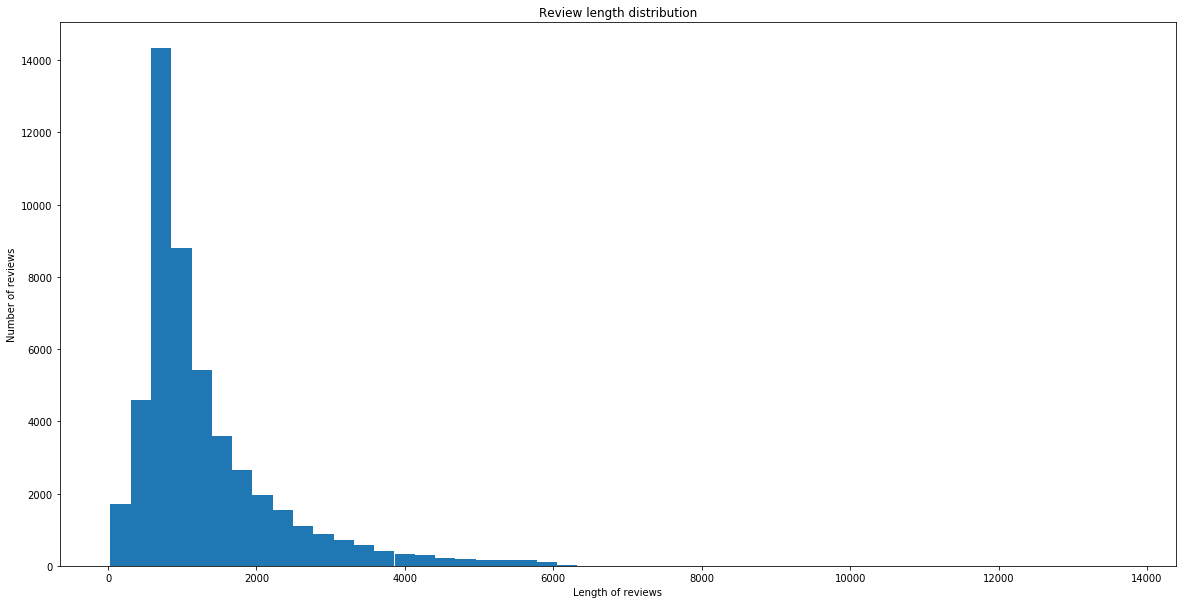

In [85]:
plt.figure(figsize=(20, 10))
plt.hist([len(rev) for rev in reviews], 50)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Review length distribution')
plt.show()

#### Plot for words frequency distribution

In [104]:
def plot_freq_dist(reviews):
    kwargs = {
        'ngram_range' : (1, 1),
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : 'word'
    }
    vectorizer = CountVectorizer(**kwargs)
    vect_texts = vectorizer.fit_transform(reviews)
    ngrams = vectorizer.get_feature_names()
    num_ngrams = min(50, len(ngrams))
    all_counts = vect_texts.sum(axis=0).tolist()[0]
    all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, ngrams), reverse=True)])
    ngrams = all_ngrams[:num_ngrams]
    counts = all_counts[:num_ngrams]

    index = np.arange(num_ngrams)

    plt.figure(figsize=(40, 40))
    plt.bar(index, counts, width=0.7)
    plt.xlabel('Words')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of words')
    plt.xticks(index, ngrams, rotation=45)
    plt.show()

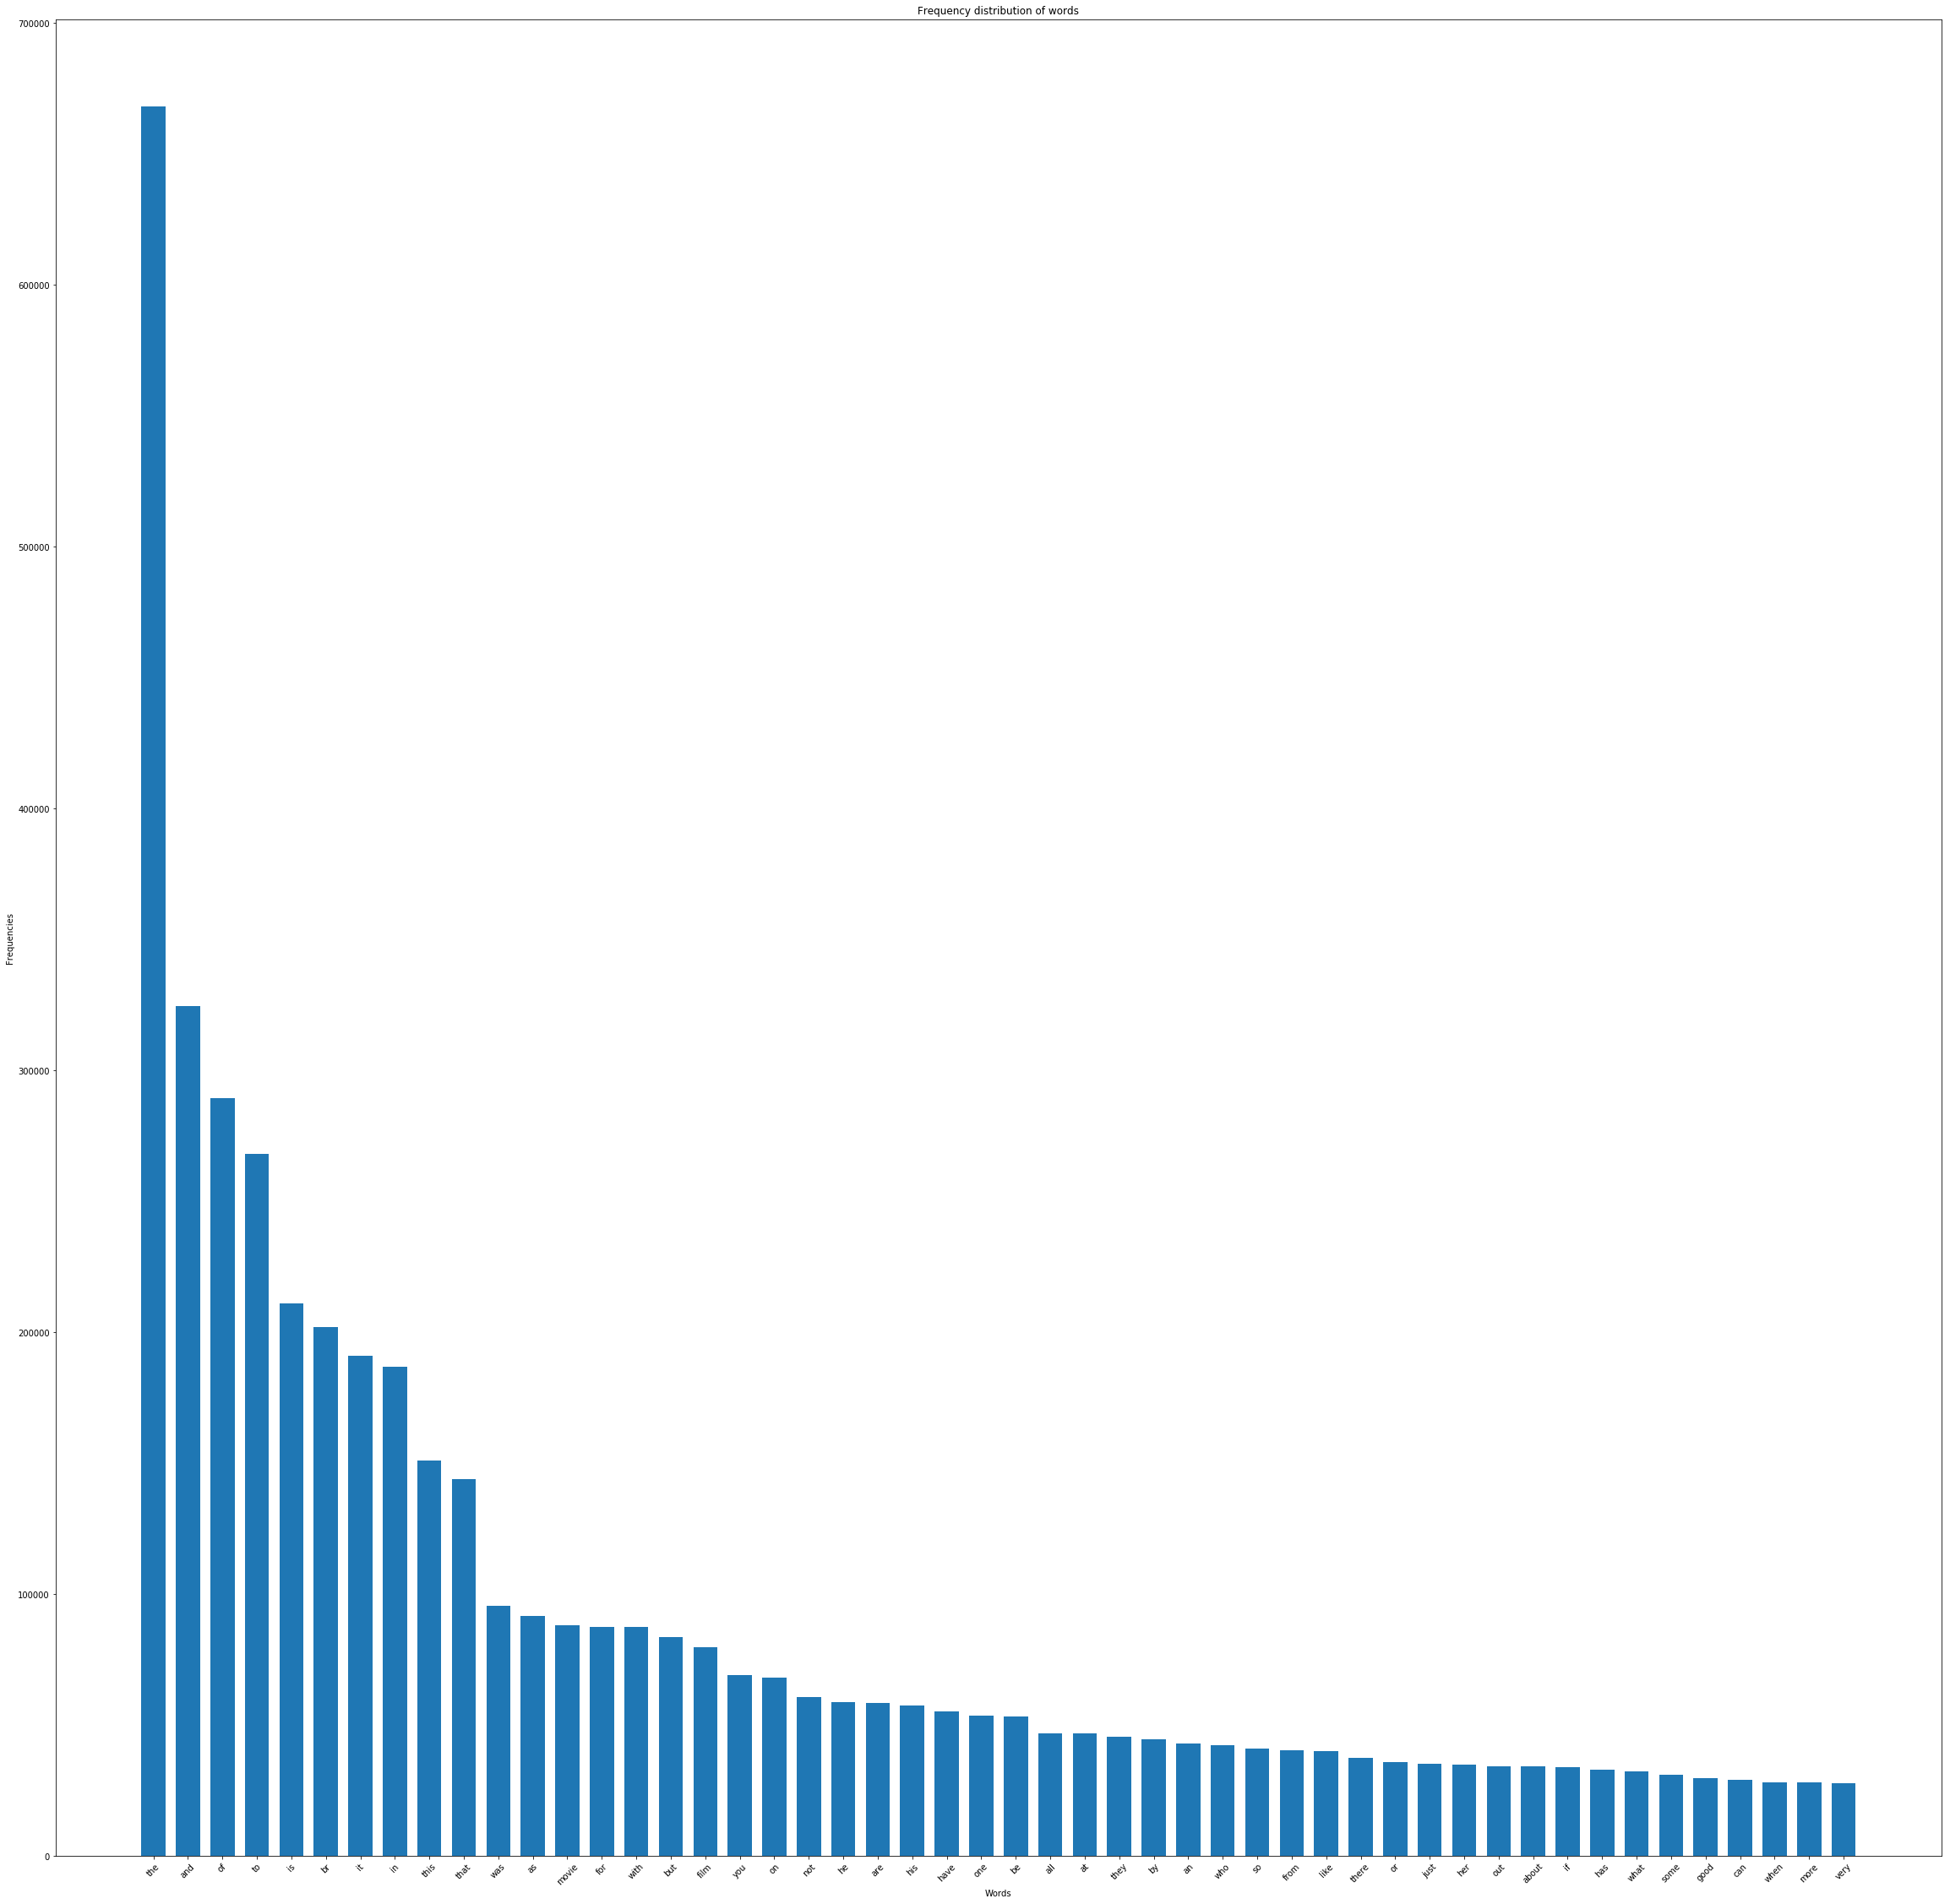

In [105]:
plot_freq_dist(reviews)

#### Preprocessing the reviews
##### Removing stop words, decoding, converting to lower case, removing special characters

In [88]:
reviews_new = []
stop_words = set(stopwords.words('english')) 
for rev in reviews:
    # Converting from byte to string and decoding utf-8
    rev = rev.decode('utf-8')
    rev = str(rev)
    # Coverting to lowercase
    rev = rev.lower()
    
    html_tags = re.compile(r'<[^>]+>')
    rev = html_tags.sub('', rev)
    rev = re.sub('[^A-Za-z0-9\']+', ' ', rev)
    rev = ' '.join([word for word in rev.split() if word not in stop_words])
    reviews_new.append(rev)

In [89]:
# Sample of reviews after preprocessing
str(reviews_new[0])

"absolute trash based closely friday 13th series practically carbon copy accept australian film people can't act upon time young boy got burnt accidentally filming music video lake eildon number years later boy grown taking revenge anybody comes lake film music video cliche ridden waste time money see curiosity aspiring actor trying learn able act lead role alan dale used star television soap opera neighbours ended x files happen"

#### Word frequency distribution after preprocessing

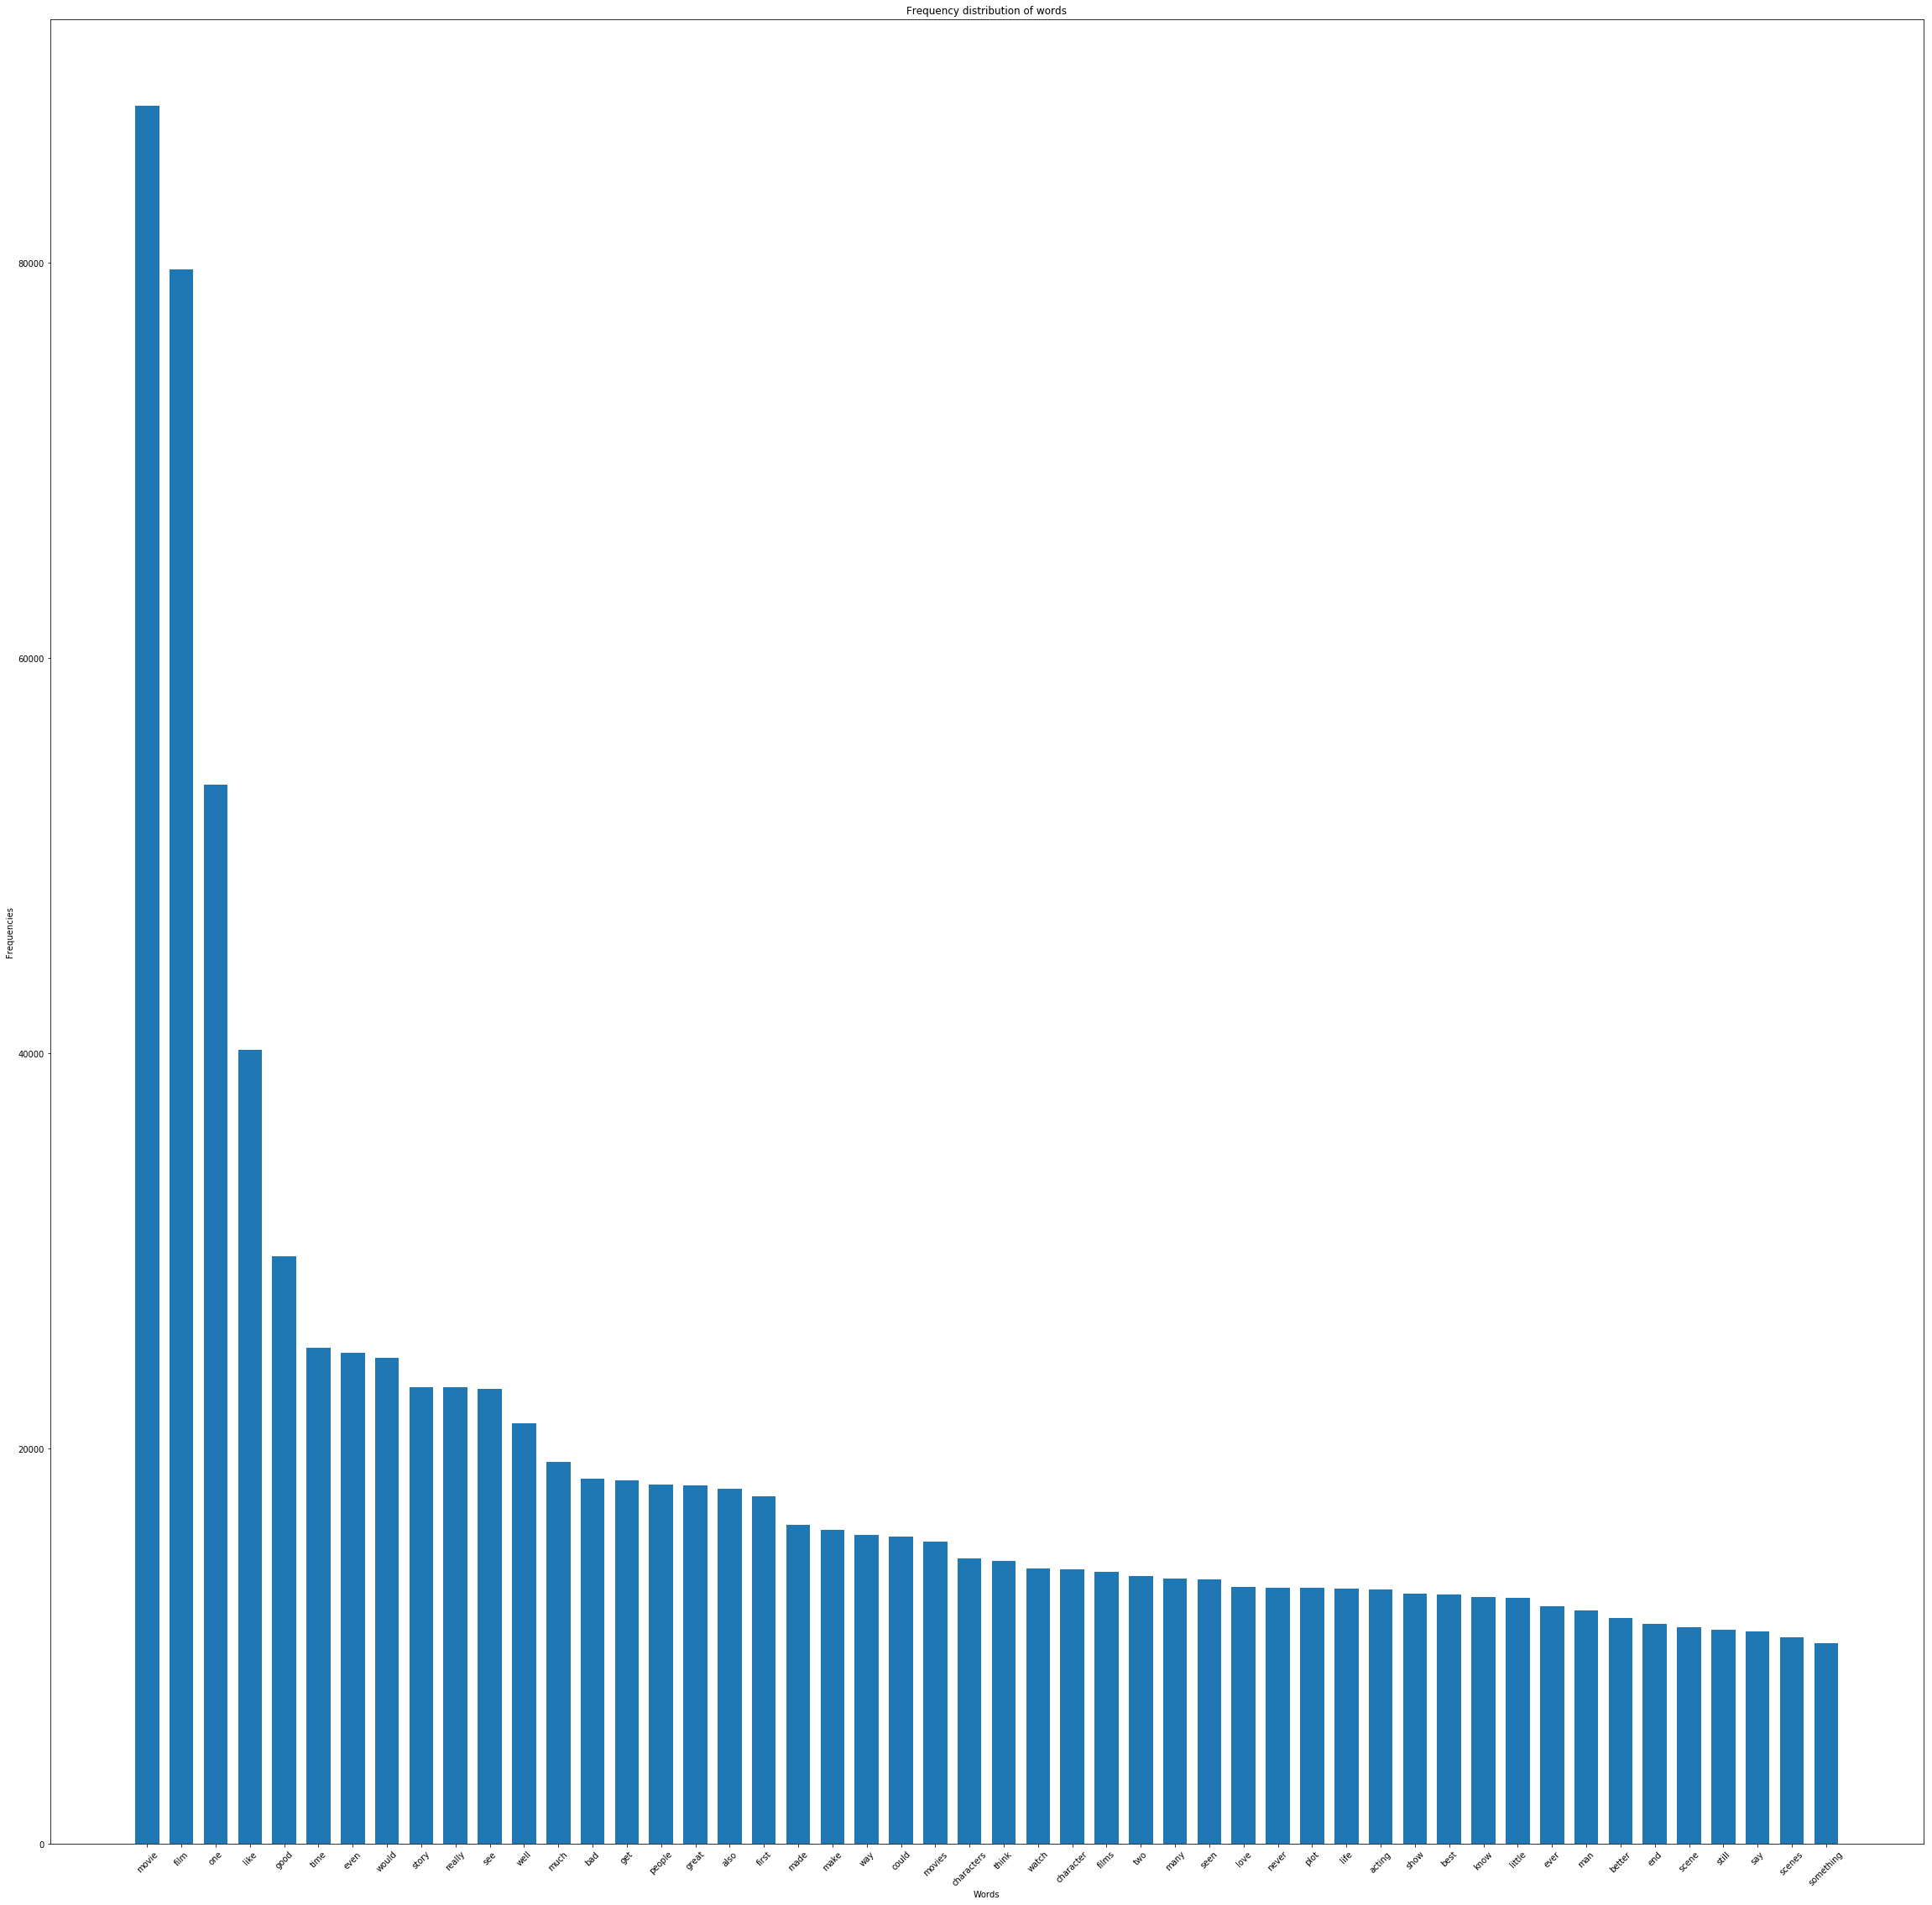

In [107]:
plot_freq_dist(reviews_new)

#### Stemming the words in the review

In [91]:
ps = PorterStemmer()
reviews_stem = []
for rev_new in reviews_new:
    rev_new = ' '.join([ps.stem(word) for word in rev_new.split()])
    reviews_stem.append(rev_new)

#### Sample of review after stemming

In [92]:
reviews_stem[0]

"absolut trash base close friday 13th seri practic carbon copi accept australian film peopl can't act upon time young boy got burnt accident film music video lake eildon number year later boy grown take reveng anybodi come lake film music video clich ridden wast time money see curios aspir actor tri learn abl act lead role alan dale use star televis soap opera neighbour end x file happen"

#### Frequency distribution for the reviews after stemming

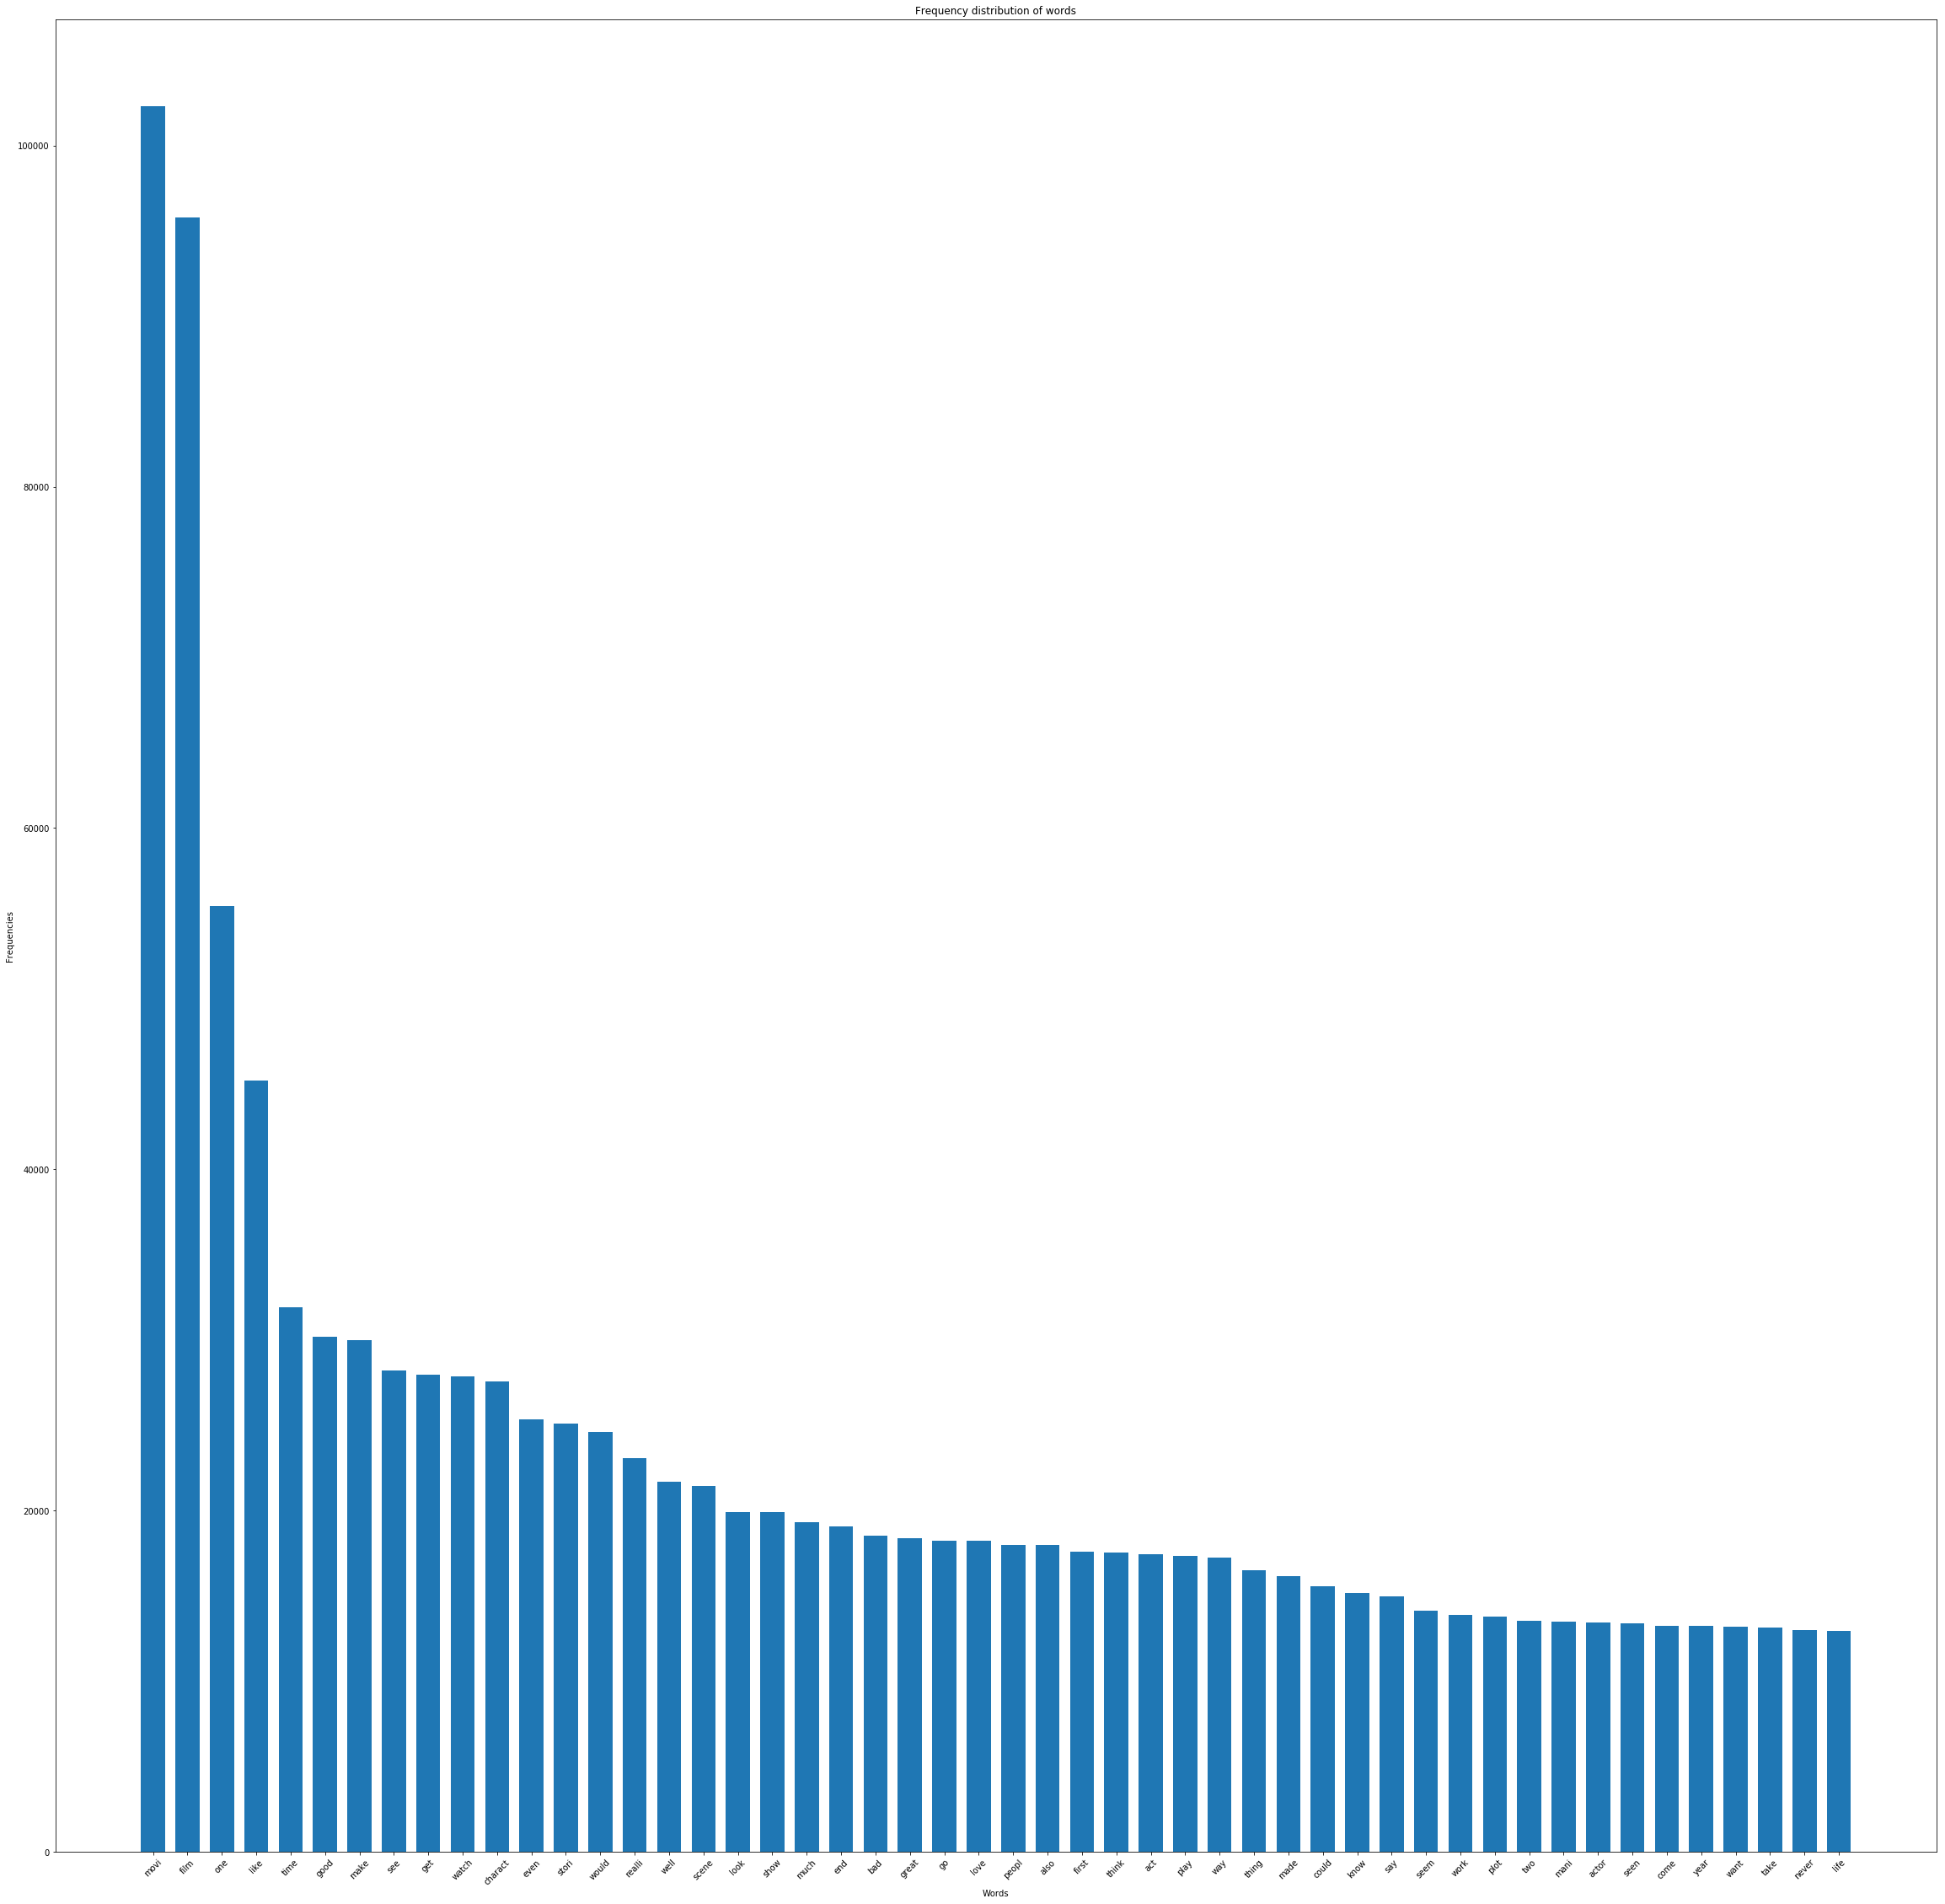

In [108]:
plot_freq_dist(reviews_stem)

#### Function to generate various metrics from confusion matrix

In [94]:
def calculate_metrics(cm):
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    # Precision
    PPV = TP/(TP+FP)
    # Sensitivity/ Recall
    TPR = TP/(TP+FN)
    # Specificity
    TNR = TN/(TN+FP) 
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # F1 Score
    F1 = 2*((PPV*TPR)/(PPV+TPR))
    return PPV, TPR, ACC, F1

#### Function to generate models and get relevant accuracy metrics for each

In [95]:

def build_model(reviews_final, max_features, min_df, max_df, model_no):
    #min document freq: term less than 3 docs, dont include
    #max_df: if word appears more then 70% of time
    #max_features: Maximum number of features
    vect = CountVectorizer(max_features = max_features, min_df = min_df, max_df = max_df)
    BOW = vect.fit_transform(reviews_new).toarray()

    
    tf_idf = TfidfTransformer()
    X = tf_idf.fit_transform(BOW).toarray()

    review_train,review_test,label_train,label_test = train_test_split(X,label,test_size = 0.30,random_state = 52)
    if(model_no == 1):
        classifier = LogisticRegression(solver = 'liblinear')
        classifier.fit(review_train,label_train)
    if(model_no==2):
        classifier = MultinomialNB()
        classifier.fit(review_train,label_train)
    if(model_no==3):
        classifier = RandomForestClassifier(n_estimators=100)
        classifier.fit(review_train,label_train)
    if(model_no==4):
        classifier = DecisionTreeClassifier()
        classifier.fit(review_train,label_train)
    classifier_name = 'classifier_'+ str(model_no) +'.pickle'
    with open(classifier_name,'wb') as f:
        pickle.dump(classifier,f)
    
    pred_labels = classifier.predict(review_test)
    cm = confusion_matrix(label_test,pred_labels)
    print(cm)
    precision, recall, accuracy, f1 = calculate_metrics(cm)
    print ("Precision", precision)
    print ("Recall", recall)
    print ("Accuracy", accuracy)
    print ("F1 score", f1)

#### Logistic Regression

In [96]:
build_model(reviews_new, 5000, 3, 0.7, 1)

[[6627  930]
 [ 784 6659]]
Precision 0.8769352917824533
Recall 0.8942113075158548
Accuracy 0.8857333333333334
F1 score 0.8854890432923569


In [97]:
build_model(reviews_stem, 5000, 3, 0.7, 1)

[[6627  930]
 [ 784 6659]]
Precision 0.8769352917824533
Recall 0.8942113075158548
Accuracy 0.8857333333333334
F1 score 0.8854890432923569


#### MultinomialNB

In [98]:
build_model(reviews_new, 5000, 3, 0.7, 2)

[[6413 1144]
 [1032 6411]]
Precision 0.8486171761280932
Recall 0.8613834788448623
Accuracy 0.8549333333333333
F1 score 0.8549526729769364


In [99]:
build_model(reviews_stem, 5000, 3, 0.7, 2)

[[6413 1144]
 [1032 6411]]
Precision 0.8486171761280932
Recall 0.8613834788448623
Accuracy 0.8549333333333333
F1 score 0.8549526729769364


#### RandomForestClassifier

In [100]:
build_model(reviews_new, 5000, 3, 0.7, 3)

[[6474 1083]
 [1228 6215]]
Precision 0.8566891623660182
Recall 0.8405608932744741
Accuracy 0.8459333333333333
F1 score 0.8485483976669506


In [101]:
build_model(reviews_stem, 5000, 3, 0.7, 3)

[[6482 1075]
 [1186 6257]]
Precision 0.8577477835119757
Recall 0.8453312467396974
Accuracy 0.8492666666666666
F1 score 0.8514942528735632


#### DecisionTreeClassifier

In [102]:
build_model(reviews_new, 5000, 3, 0.7, 4)

[[5454 2103]
 [2126 5317]]
Precision 0.7217149662564509
Recall 0.7195250659630607
Accuracy 0.7180666666666666
F1 score 0.7206183523815815


In [103]:
build_model(reviews_stem, 5000, 3, 0.7, 4)

[[5441 2116]
 [2123 5320]]
Precision 0.7199947068942703
Recall 0.7193283976731888
Accuracy 0.7174
F1 score 0.7196613980556842
